In [1]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

In [2]:
file_list = []
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
0,./dataset\segmentations,segmentation-0.nii
1,./dataset\segmentations,segmentation-1.nii
2,./dataset\segmentations,segmentation-10.nii
3,./dataset\segmentations,segmentation-100.nii
4,./dataset\segmentations,segmentation-101.nii
...,...,...
227,./dataset\volume_pt6,volume-95.nii
228,./dataset\volume_pt6,volume-96.nii
229,./dataset\volume_pt6,volume-97.nii
230,./dataset\volume_pt6,volume-98.nii


In [3]:
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "./dataset/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,./dataset\volume_pt1,volume-0.nii,./dataset/segmentations,segmentation-0.nii
1,./dataset\volume_pt1,volume-1.nii,./dataset/segmentations,segmentation-1.nii
2,./dataset\volume_pt1,volume-10.nii,./dataset/segmentations,segmentation-10.nii
3,./dataset\volume_pt6,volume-100.nii,./dataset/segmentations,segmentation-100.nii
4,./dataset\volume_pt8,volume-101.nii,./dataset/segmentations,segmentation-101.nii
...,...,...,...,...
126,./dataset\volume_pt6,volume-95.nii,./dataset/segmentations,segmentation-95.nii
127,./dataset\volume_pt6,volume-96.nii,./dataset/segmentations,segmentation-96.nii
128,./dataset\volume_pt6,volume-97.nii,./dataset/segmentations,segmentation-97.nii
129,./dataset\volume_pt6,volume-98.nii,./dataset/segmentations,segmentation-98.nii


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [6]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


In [7]:
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 262144]]


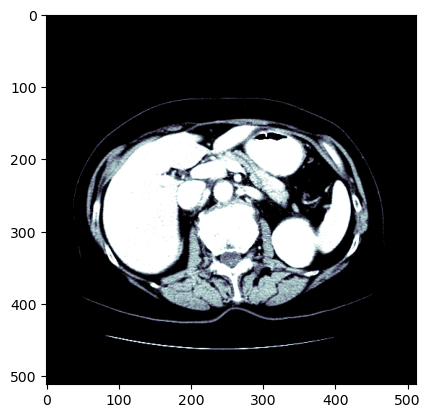

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Your defined DICOM windows
dicom_windows = {
    'liver': (150, 30)
}


def window_image_np(array, w, l):
    img_min = l - w // 2
    img_max = l + w // 2
    windowed_array = np.clip(array, img_min, img_max)
    return (windowed_array - img_min) / (img_max - img_min)

# Assuming 'sample_ct' is a NumPy array you have previously loaded
sample_ct_np = sample_ct.astype(np.float32)

# Apply the windowing function to the selected slice
windowed_ct_np = window_image_np(sample_ct_np[..., 55], *dicom_windows['liver'])

# Display the windowed image
plt.imshow(windowed_ct_np, cmap=plt.cm.bone)
plt.show()

In [12]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from tqdm import tqdm

# save the image as PNG using NumPy arrays
def save_image_np(array, path):
    im = Image.fromarray((array * 255).astype(np.uint8), mode="L")
    im.save(path, format='PNG')

# Directory setup for saving images
os.makedirs('train_images', exist_ok=True)
os.makedirs('train_masks', exist_ok=True)

# Iterate through the DataFrame and process each CT scan
for i, row in tqdm(df_files.iterrows(), total=df_files.shape[0]):
    ct_file_path = os.path.join(row['dirname'], row['filename']).replace('\\', '/')
    mask_file_path = os.path.join(row['mask_dirname'], row['mask_filename']).replace('\\', '/')

    # Read the CT scan and mask
    ct = read_nii(ct_file_path)
    mask = read_nii(mask_file_path)

    for slice_idx in range(ct.shape[2]):
        # Process each slice
        ct_slice = ct[..., slice_idx].astype(np.float32)
        mask_slice = mask[..., slice_idx].astype(np.float32)

        # Apply windowing to the CT slice
        ct_slice_windowed = window_image_np(ct_slice, *dicom_windows['liver'])
        # Save the CT slice and mask slice as PNG
        save_image_np(ct_slice_windowed, f'train_images/slice_{i}_{slice_idx}.png')
        save_image_np(mask_slice, f'train_masks/slice_{i}_{slice_idx}.png')

  7%|▋         | 9/131 [01:28<19:55,  9.80s/it]


KeyboardInterrupt: 

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

class LiverSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, min_white_pixels=10):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = []
        self.masks = []

        all_image_names = os.listdir(image_dir)
        for img_name in all_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)

            mask = Image.open(mask_path).convert('L')
            mask_np = np.array(mask)
            
            # Check if the mask has at least min_white_pixels white pixels
            if np.sum(mask_np > 0) >= min_white_pixels:
                self.images.append(img_name)  # add the image name
                self.masks.append(img_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            # Apply image transforms (including normalization)
            image = self.transform(image)

        if mask_transform:
            # Apply mask transforms (without normalization)
            mask = mask_transform(mask)

        mask = (mask > 0).float()

        return image, mask

mean = [0.485]
std = [0.229]

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean, std)
])
mask_transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

# Instantiate the dataset with the transformations
dataset = LiverSegmentationDataset(
    image_dir='train_images',
    mask_dir='train_masks',
    transform=transform,
    mask_transform=mask_transform
)

# Split the dataset
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Create dataloaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
def calculate_f1_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from unet_model import UNet
from tqdm import tqdm

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the U-Net model
model = UNet(n_channels=1, n_classes=1).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Create the results directory if it doesn't exist
results_dir = './result'
os.makedirs(results_dir, exist_ok=True)

# Training and validation loop
num_epochs = 20
best_valid_loss = float('inf')

# Function to save the image, mask, and prediction
def save_visualization(image, mask, pred, batch_idx, phase):
    image = image.squeeze().cpu().detach().numpy()
    mask = mask.squeeze().cpu().detach().numpy()
    pred = torch.sigmoid(pred).squeeze().cpu().detach().numpy()
    pred_thresholded = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_thresholded, cmap='gray')
    plt.title('Prediction (Thresholded)')

    # Save the figure
    plt.savefig(os.path.join(results_dir, f'{phase}_batch_{batch_idx}.png'))
    plt.close()

# Add initialization for F1 score logs
train_f1_scores = []
valid_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    valid_f1_scores.clear()
    # Wrap the training loader with tqdm for a progress bar
    train_loader_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN]')
    
    for batch_idx, (images, masks) in enumerate(train_loader_pbar):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        # Update the tqdm progress bar with the current loss
        train_loader_pbar.set_postfix({'loss': loss.item()})
        
        # Save visualizations for specific batches
        if batch_idx == 800:
            save_visualization(images[0], masks[0], outputs[0], batch_idx, 'train')

    # Validation phase
    model.eval()
    valid_loss = 0.0
    # Wrap the validation loader with tqdm for a progress bar
    valid_loader_pbar = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [VALID]')
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(valid_loader_pbar):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            valid_loss += loss.item() * images.size(0)
            # Update the tqdm progress bar with the current loss
            valid_loader_pbar.set_postfix({'loss': loss.item()})
            
            if batch_idx == 110:
                save_visualization(images[0], masks[0], outputs[0], batch_idx, 'valid')
                
            # Calculate F1 score
            preds_binary = (torch.sigmoid(outputs) > 0.5).float()
            f1_score = calculate_f1_score(masks.cpu().numpy(), preds_binary.cpu().numpy())
            valid_f1_scores.append(f1_score)
          
    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    mean_valid_f1 = np.mean(valid_f1_scores)
    # Step the scheduler
    scheduler.step(valid_loss)

    # Write the losses to file
    with open(os.path.join(results_dir, 'losses.txt'), 'a') as f:
        f.write(f'{epoch+1},{train_loss:.4f},{valid_loss:.4f}\n')
        
    # Write the F1 scores to file
    with open(os.path.join(results_dir, 'performance.txt'), 'a') as f:
        f.write(f'{epoch+1},{mean_valid_f1:.4f}\n')

    # Print training and validation loss at the end of the epoch
    print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}\n')

    # Save the model every 2 epochs
    if (epoch+1) % 1 == 0:
        torch.save(model.state_dict(), os.path.join(results_dir, f'unet_liver_segmentation_epoch_{epoch+1}.pth'))

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(results_dir, 'unet_liver_segmentation_best.pth'))

# Save the last model checkpoint
torch.save(model.state_dict(), os.path.join(results_dir, 'unet_liver_segmentation_last.pth'))

Epoch 1/20 [VALID]: 100%|██████████| 180/180 [00:45<00:00,  3.95it/s, loss=0.0701]



Epoch 1/20, Train Loss: 0.0715, Valid Loss: 0.0659



Epoch 2/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.05it/s, loss=0.0226] 



Epoch 2/20, Train Loss: 0.0221, Valid Loss: 0.0162



Epoch 3/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.03it/s, loss=0.0122] 



Epoch 3/20, Train Loss: 0.0146, Valid Loss: 0.0118



Epoch 4/20 [VALID]: 100%|██████████| 180/180 [00:43<00:00,  4.11it/s, loss=0.0136] 



Epoch 4/20, Train Loss: 0.0118, Valid Loss: 0.0110



Epoch 5/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.05it/s, loss=0.0116] 



Epoch 5/20, Train Loss: 0.0112, Valid Loss: 0.0095



Epoch 6/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.05it/s, loss=0.00982]



Epoch 6/20, Train Loss: 0.0093, Valid Loss: 0.0125



Epoch 7/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.03it/s, loss=0.00795]



Epoch 7/20, Train Loss: 0.0091, Valid Loss: 0.0081



Epoch 8/20 [VALID]: 100%|██████████| 180/180 [00:43<00:00,  4.16it/s, loss=0.0123] 



Epoch 8/20, Train Loss: 0.0079, Valid Loss: 0.0094



Epoch 9/20 [VALID]: 100%|██████████| 180/180 [00:58<00:00,  3.05it/s, loss=0.00796]



Epoch 9/20, Train Loss: 0.0089, Valid Loss: 0.0075



Epoch 10/20 [VALID]: 100%|██████████| 180/180 [00:43<00:00,  4.15it/s, loss=0.0143] 



Epoch 10/20, Train Loss: 0.0074, Valid Loss: 0.0108



Epoch 11/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.03it/s, loss=0.00648]



Epoch 11/20, Train Loss: 0.0078, Valid Loss: 0.0069



Epoch 12/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.05it/s, loss=0.00663]



Epoch 12/20, Train Loss: 0.0065, Valid Loss: 0.0067



Epoch 13/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.01it/s, loss=0.00604]



Epoch 13/20, Train Loss: 0.0076, Valid Loss: 0.0066



Epoch 14/20 [VALID]: 100%|██████████| 180/180 [00:43<00:00,  4.11it/s, loss=0.0067] 



Epoch 14/20, Train Loss: 0.0060, Valid Loss: 0.0062



Epoch 15/20 [VALID]: 100%|██████████| 180/180 [00:43<00:00,  4.09it/s, loss=0.00577]



Epoch 15/20, Train Loss: 0.0057, Valid Loss: 0.0061



Epoch 16/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.05it/s, loss=0.00641]



Epoch 16/20, Train Loss: 0.0056, Valid Loss: 0.0063



Epoch 17/20 [VALID]: 100%|██████████| 180/180 [00:46<00:00,  3.86it/s, loss=0.0065] 



Epoch 17/20, Train Loss: 0.0064, Valid Loss: 0.0058



Epoch 18/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.06it/s, loss=0.00493]



Epoch 18/20, Train Loss: 0.0050, Valid Loss: 0.0054



Epoch 19/20 [VALID]: 100%|██████████| 180/180 [00:44<00:00,  4.09it/s, loss=0.00513]



Epoch 19/20, Train Loss: 0.0048, Valid Loss: 0.0054



Epoch 20/20 [VALID]: 100%|██████████| 180/180 [00:59<00:00,  3.01it/s, loss=0.0048] 



Epoch 20/20, Train Loss: 0.0047, Valid Loss: 0.0052



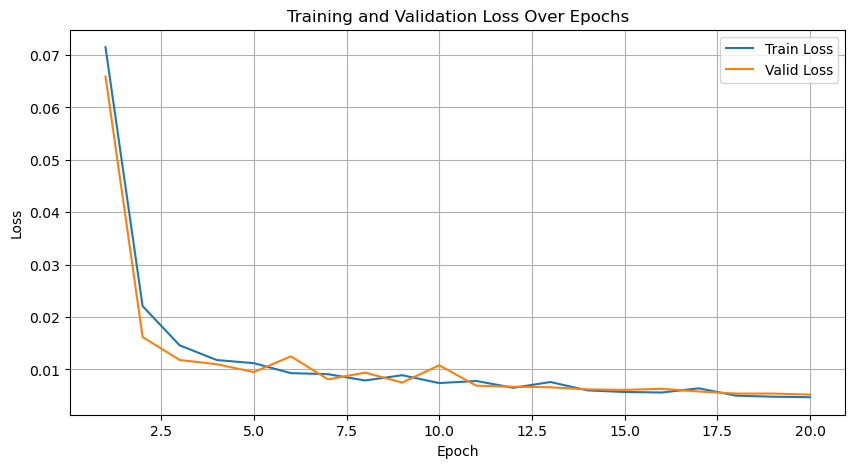

In [ ]:
# Load the losses data
losses_df = pd.read_csv('./result/losses.txt', header=None, names=['Epoch', 'TrainLoss', 'ValidLoss'])

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(losses_df['Epoch'], losses_df['TrainLoss'], label='Train Loss')
plt.plot(losses_df['Epoch'], losses_df['ValidLoss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'loss.png'))
plt.show()

NameError: name 'results_dir' is not defined

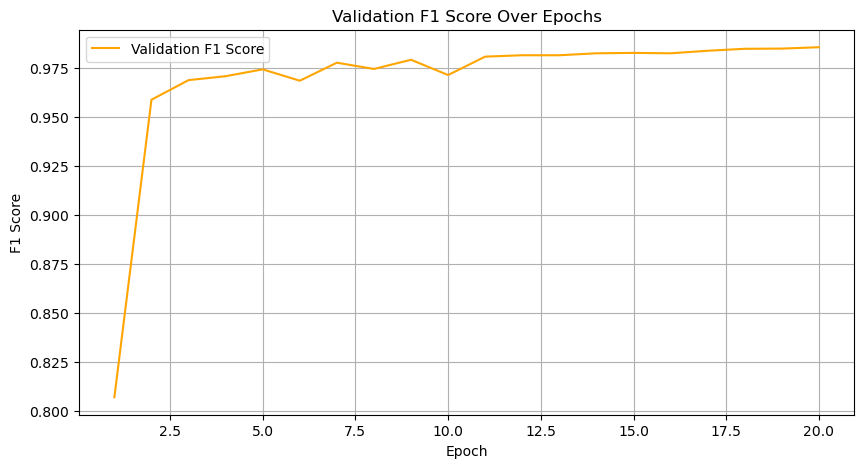

In [ ]:
# Load the performance data
performance_df = pd.read_csv('./result/performance.txt', header=None, names=['Epoch', 'F1Score'])

# Plot the F1 Score
plt.figure(figsize=(10, 5))
plt.plot(performance_df['Epoch'], performance_df['F1Score'], label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'f1_score.png'))
plt.show()

In [ ]:
import torch
import numpy as np
from unet_model import UNet
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(torch.load("./result/unet_liver_segmentation_best.pth"))
model.eval()


model = model.to(device)


true_labels = []
predicted_labels = []


with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        

        preds = torch.sigmoid(outputs) > 0.5
        
        true_labels.append(masks.cpu().numpy())
        predicted_labels.append(preds.cpu().numpy())

# Flatten the lists and compute the F1 score
true_labels = np.vstack(true_labels).flatten()
predicted_labels = np.vstack(predicted_labels).flatten()
test_f1_score = calculate_f1_score(true_labels, predicted_labels)

print(f'F1 Score on the test set: {test_f1_score}')

F1 Score on the test set: 0.9855244474019398


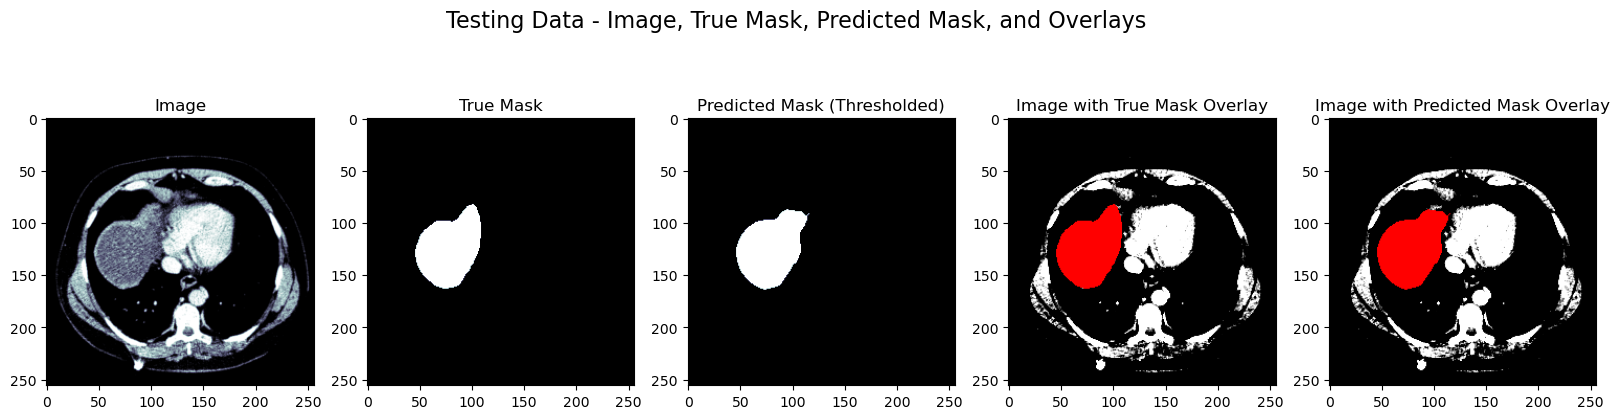

In [ ]:
from matplotlib import cm
import torch
import numpy as np
from unet_model import UNet
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(torch.load("./result/unet_liver_segmentation_best.pth"))
model.eval()

results_dir = './result'
model = model.to(device)

def overlay_mask(img, mask, color='red', alpha=0.5):
    """ Overlay mask on the image. """
    # Create an RGB version of the grayscale image
    img_rgb = cm.gray(img)[:,:,:3]
    mask_idx = np.where(mask == 1)
    img_rgb[mask_idx[0], mask_idx[1], :] = np.array(cm.colors.to_rgb(color))
    combined = (img_rgb * alpha + img_rgb * (1 - alpha)).clip(0, 1)
    return combined

# Visualize one example with overlay
image, mask = next(iter(test_loader))
image = image.to(device)
mask = mask.to(device)
output = model(image)

# Apply sigmoid to output to get the probability map
output_prob = torch.sigmoid(output)

# Apply threshold to turn it into a binary mask
threshold = 0.5
output_bin = (output_prob > threshold).float()

# Convert to numpy arrays for visualization
image_np = image[0].squeeze().cpu().numpy()
mask_np = mask[0].squeeze().cpu().numpy()
output_np = output_bin[0].squeeze().cpu().detach().numpy()

# Overlay the masks on the image
overlay_true = overlay_mask(image_np, mask_np)
overlay_pred = overlay_mask(image_np, output_np)

plt.figure(figsize=(20, 5))
plt.suptitle('Testing Data - Image, True Mask, Predicted Mask, and Overlays', fontsize=16)

plt.subplot(1, 5, 1)
plt.imshow(image_np, cmap='bone')
plt.title('Image')

plt.subplot(1, 5, 2)
plt.imshow(mask_np, cmap='bone')
plt.title('True Mask')

plt.subplot(1, 5, 3)
plt.imshow(output_np, cmap='bone')
plt.title('Predicted Mask (Thresholded)')

plt.subplot(1, 5, 4)
plt.imshow(overlay_true)
plt.title('Image with True Mask Overlay')

plt.subplot(1, 5, 5)
plt.imshow(overlay_pred)
plt.title('Image with Predicted Mask Overlay')

plt.savefig(os.path.join(results_dir, 'test.png'))
plt.show()

In [ ]:
import torch
import torch.onnx


model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(torch.load("./result/unet_liver_segmentation_best.pth"))
model.eval()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


dummy_input = torch.randn(1, 1, 256, 256, device=device)

output_path = "./result/unet_liver_segmentation.onnx"
torch.onnx.export(model, dummy_input, output_path, export_params=True, opset_version=11, 
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

print(f"Model was successfully exported to {output_path}")

c:\Users\syed_fahim_ahmed\anaconda3\envs\topo_loss\lib\site-packages\torch\onnx\utils.py:688: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  graph, params_dict, GLOBALS.export_onnx_opset_version
c:\Users\syed_fahim_ahmed\anaconda3\envs\topo_loss\lib\site-packages\torch\onnx\utils.py:688: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  graph, params_dict, GLOBALS.export_onnx_opset_version
c:\Users\syed_fahim_ahmed\anaconda3\envs\topo_loss\lib\site-packages\torch\onnx\utils.py:1179: UserWarning: The shape inference of prim::Constant type is missing,

Model was successfully exported to ./result/unet_liver_segmentation.onnx


In [10]:
# Modify the save_image_np function to save only tumor mask (value 2 becomes 1, others become 0)
def save_tumor_image_np(array, path, is_mask=False):
    if is_mask:
        array = np.where(array == 2, 1, 0)  # Setting tumor as 1, rest as 0
    im = Image.fromarray((array * 255).astype(np.uint8), mode="L")
    im.save(path, format='PNG')

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

os.makedirs('train_tumor_images', exist_ok=True)
os.makedirs('train_tumor_masks', exist_ok=True)

# Iterate through the DataFrame and process each CT scan
for i, row in tqdm(df_files.iterrows(), total=df_files.shape[0]):
    ct_file_path = os.path.join(row['dirname'], row['filename']).replace('\\', '/')
    mask_file_path = os.path.join(row['mask_dirname'], row['mask_filename']).replace('\\', '/')

    # Read the CT scan and mask
    ct = read_nii(ct_file_path)
    mask = read_nii(mask_file_path)

    for slice_idx in range(ct.shape[2]):
        # Process each slice
        ct_slice = ct[..., slice_idx].astype(np.float32)
        mask_slice = mask[..., slice_idx].astype(np.float32)

        # Apply windowing to the CT slice
        ct_slice_windowed = window_image_np(ct_slice, *dicom_windows['liver'])
        # Save the CT slice and the tumor mask slice as PNG
        save_tumor_image_np(ct_slice_windowed, f'train_tumor_images/slice_{i}_{slice_idx}.png')
        save_tumor_image_np(mask_slice, f'train_tumor_masks/slice_{i}_{slice_idx}.png', is_mask=True)

100%|██████████| 131/131 [16:49<00:00,  7.71s/it]


In [3]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

class LiverTumorSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, min_white_pixels=10):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = []
        self.masks = []

        all_image_names = os.listdir(image_dir)
        for img_name in all_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)

            mask = Image.open(mask_path).convert('L')
            mask_np = np.array(mask)
            
            # Check if the mask has at least min_white_pixels white pixels
            if np.sum(mask_np > 0) >= min_white_pixels:
                self.images.append(img_name)  # add the image name
                self.masks.append(img_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (np.array(mask) > 0).astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

mean = [0.485]
std = [0.229]

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean, std)
])
mask_transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

# Instantiate the dataset with the transformations
dataset = LiverTumorSegmentationDataset(
    image_dir='train_tumor_images',
    mask_dir='train_tumor_masks',
    transform=transform,
    mask_transform=mask_transform
)

# Split the dataset
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Create dataloaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Assuming you have a function to calculate the weights for each mask in a batch
def calculate_pos_weight(mask):
    num_white = torch.sum(mask == 1).item()
    num_black = torch.sum(mask == 0).item()
    return num_black / (num_white + 1)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from unet_model import UNet
from tqdm import tqdm

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the U-Net model
model = UNet(n_channels=1, n_classes=1).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Create the results directory if it doesn't exist
results_dir = './tumor_result'
os.makedirs(results_dir, exist_ok=True)

# Training and validation loop
num_epochs = 50
best_valid_loss = float('inf')

# Function to save the image, mask, and prediction
def save_visualization(image, mask, pred, batch_idx, phase):
    image = image.squeeze().cpu().detach().numpy()
    mask = mask.squeeze().cpu().detach().numpy()
    pred = torch.sigmoid(pred).squeeze().cpu().detach().numpy()
    pred_thresholded = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_thresholded, cmap='gray')
    plt.title('Prediction (Thresholded)')

    # Save the figure
    plt.savefig(os.path.join(results_dir, f'{phase}_batch_{batch_idx}.png'))
    plt.close()

# Add initialization for F1 score logs
train_f1_scores = []
valid_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    valid_f1_scores.clear()
    # Wrap the training loader with tqdm for a progress bar
    train_loader_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN]')
    
    for batch_idx, (images, masks) in enumerate(train_loader_pbar):
        images = images.to(device)
        masks = masks.to(device)

        # Calculate the weight for positive examples in the batch
        pos_weight = calculate_pos_weight(masks)
        pos_weight_tensor = torch.tensor([pos_weight], device=device)
        
        # Use this weight in the BCEWithLogitsLoss
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        # Update the tqdm progress bar with the current loss
        train_loader_pbar.set_postfix({'loss': loss.item()})
        
        # Save visualizations for specific batches
        if batch_idx == 300:
            save_visualization(images[0], masks[0], outputs[0], batch_idx, 'train')

    # Validation phase
    model.eval()
    valid_loss = 0.0
    # Wrap the validation loader with tqdm for a progress bar
    valid_loader_pbar = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [VALID]')
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(valid_loader_pbar):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            valid_loss += loss.item() * images.size(0)
            # Update the tqdm progress bar with the current loss
            valid_loader_pbar.set_postfix({'loss': loss.item()})
            
            if batch_idx == 15:
                save_visualization(images[0], masks[0], outputs[0], batch_idx, 'valid')
                
            # Calculate F1 score
            preds_binary = (torch.sigmoid(outputs) > 0.5).float()
            f1_score = calculate_f1_score(masks.cpu().numpy(), preds_binary.cpu().numpy())
            valid_f1_scores.append(f1_score)
          
    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    mean_valid_f1 = np.mean(valid_f1_scores)
    # Step the scheduler
    scheduler.step(valid_loss)

    # Write the losses to file
    with open(os.path.join(results_dir, 'losses.txt'), 'a') as f:
        f.write(f'{epoch+1},{train_loss:.4f},{valid_loss:.4f}\n')
        
    # Write the F1 scores to file
    with open(os.path.join(results_dir, 'performance.txt'), 'a') as f:
        f.write(f'{epoch+1},{mean_valid_f1:.4f}\n')

    # Print training and validation loss at the end of the epoch
    print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}\n')

    # Save the model every 2 epochs
    if (epoch+1) % 1 == 0:
        torch.save(model.state_dict(), os.path.join(results_dir, f'unet_liver_tumor_segmentation_epoch_{epoch+1}.pth'))

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(results_dir, 'unet_liver_tumor_segmentation_best.pth'))

# Save the last model checkpoint
torch.save(model.state_dict(), os.path.join(results_dir, 'unet_liver_tumor_segmentation_last.pth'))

Epoch 1/50 [TRAIN]:   0%|          | 0/310 [00:00<?, ?it/s]

x1 shape:  torch.Size([16, 64, 256, 256])
x2 shape:  torch.Size([16, 128, 128, 128])
x3 shape:  torch.Size([16, 256, 64, 64])
x4 shape:  torch.Size([16, 512, 32, 32])
x5 shape:  torch.Size([16, 1024, 16, 16])
x1 shape before up:  torch.Size([16, 512, 32, 32])
x1 shape after up:  torch.Size([16, 512, 32, 32])
x shape up:  torch.Size([16, 1024, 32, 32])
x shape after conv:  torch.Size([16, 512, 32, 32])
x shape after up1:  torch.Size([16, 512, 32, 32])
x1 shape before up:  torch.Size([16, 256, 64, 64])
x1 shape after up:  torch.Size([16, 256, 64, 64])
x shape up:  torch.Size([16, 512, 64, 64])
x shape after conv:  torch.Size([16, 256, 64, 64])
x shape after up2:  torch.Size([16, 256, 64, 64])
x1 shape before up:  torch.Size([16, 128, 128, 128])
x1 shape after up:  torch.Size([16, 128, 128, 128])
x shape up:  torch.Size([16, 256, 128, 128])
x shape after conv:  torch.Size([16, 128, 128, 128])
x shape:  torch.Size([16, 128, 128, 128])
x1 shape before up:  torch.Size([16, 64, 256, 256])
x1 

Epoch 1/50 [TRAIN]:   0%|          | 1/310 [00:03<18:07,  3.52s/it, loss=1.39]

x1 shape:  torch.Size([16, 64, 256, 256])
x2 shape:  torch.Size([16, 128, 128, 128])
x3 shape:  torch.Size([16, 256, 64, 64])
x4 shape:  torch.Size([16, 512, 32, 32])
x5 shape:  torch.Size([16, 1024, 16, 16])
x1 shape before up:  torch.Size([16, 512, 32, 32])
x1 shape after up:  torch.Size([16, 512, 32, 32])
x shape up:  torch.Size([16, 1024, 32, 32])
x shape after conv:  torch.Size([16, 512, 32, 32])
x shape after up1:  torch.Size([16, 512, 32, 32])
x1 shape before up:  torch.Size([16, 256, 64, 64])
x1 shape after up:  torch.Size([16, 256, 64, 64])
x shape up:  torch.Size([16, 512, 64, 64])
x shape after conv:  torch.Size([16, 256, 64, 64])
x shape after up2:  torch.Size([16, 256, 64, 64])
x1 shape before up:  torch.Size([16, 128, 128, 128])
x1 shape after up:  torch.Size([16, 128, 128, 128])
x shape up:  torch.Size([16, 256, 128, 128])
x shape after conv:  torch.Size([16, 128, 128, 128])
x shape:  torch.Size([16, 128, 128, 128])
x1 shape before up:  torch.Size([16, 64, 256, 256])
x1 

Epoch 1/50 [TRAIN]:   1%|          | 2/310 [00:04<09:03,  1.76s/it, loss=1.13]

x1 shape:  torch.Size([16, 64, 256, 256])
x2 shape:  torch.Size([16, 128, 128, 128])
x3 shape:  torch.Size([16, 256, 64, 64])
x4 shape:  torch.Size([16, 512, 32, 32])
x5 shape:  torch.Size([16, 1024, 16, 16])
x1 shape before up:  torch.Size([16, 512, 32, 32])
x1 shape after up:  torch.Size([16, 512, 32, 32])
x shape up:  torch.Size([16, 1024, 32, 32])
x shape after conv:  torch.Size([16, 512, 32, 32])
x shape after up1:  torch.Size([16, 512, 32, 32])
x1 shape before up:  torch.Size([16, 256, 64, 64])
x1 shape after up:  torch.Size([16, 256, 64, 64])
x shape up:  torch.Size([16, 512, 64, 64])
x shape after conv:  torch.Size([16, 256, 64, 64])
x shape after up2:  torch.Size([16, 256, 64, 64])
x1 shape before up:  torch.Size([16, 128, 128, 128])
x1 shape after up:  torch.Size([16, 128, 128, 128])
x shape up:  torch.Size([16, 256, 128, 128])
x shape after conv:  torch.Size([16, 128, 128, 128])
x shape:  torch.Size([16, 128, 128, 128])
x1 shape before up:  torch.Size([16, 64, 256, 256])
x1 

Epoch 1/50 [TRAIN]:   1%|          | 3/310 [00:04<06:07,  1.20s/it, loss=1.05]

x1 shape:  torch.Size([16, 64, 256, 256])
x2 shape:  torch.Size([16, 128, 128, 128])
x3 shape:  torch.Size([16, 256, 64, 64])
x4 shape:  torch.Size([16, 512, 32, 32])
x5 shape:  torch.Size([16, 1024, 16, 16])
x1 shape before up:  torch.Size([16, 512, 32, 32])
x1 shape after up:  torch.Size([16, 512, 32, 32])
x shape up:  torch.Size([16, 1024, 32, 32])
x shape after conv:  torch.Size([16, 512, 32, 32])
x shape after up1:  torch.Size([16, 512, 32, 32])
x1 shape before up:  torch.Size([16, 256, 64, 64])
x1 shape after up:  torch.Size([16, 256, 64, 64])
x shape up:  torch.Size([16, 512, 64, 64])
x shape after conv:  torch.Size([16, 256, 64, 64])
x shape after up2:  torch.Size([16, 256, 64, 64])
x1 shape before up:  torch.Size([16, 128, 128, 128])
x1 shape after up:  torch.Size([16, 128, 128, 128])
x shape up:  torch.Size([16, 256, 128, 128])
x shape after conv:  torch.Size([16, 128, 128, 128])
x shape:  torch.Size([16, 128, 128, 128])
x1 shape before up:  torch.Size([16, 64, 256, 256])
x1 

Epoch 1/50 [TRAIN]:   1%|▏         | 4/310 [00:05<04:45,  1.07it/s, loss=0.906]

x1 shape:  torch.Size([16, 64, 256, 256])
x2 shape:  torch.Size([16, 128, 128, 128])
x3 shape:  torch.Size([16, 256, 64, 64])
x4 shape:  torch.Size([16, 512, 32, 32])
x5 shape:  torch.Size([16, 1024, 16, 16])
x1 shape before up:  torch.Size([16, 512, 32, 32])
x1 shape after up:  torch.Size([16, 512, 32, 32])
x shape up:  torch.Size([16, 1024, 32, 32])
x shape after conv:  torch.Size([16, 512, 32, 32])
x shape after up1:  torch.Size([16, 512, 32, 32])
x1 shape before up:  torch.Size([16, 256, 64, 64])
x1 shape after up:  torch.Size([16, 256, 64, 64])
x shape up:  torch.Size([16, 512, 64, 64])
x shape after conv:  torch.Size([16, 256, 64, 64])
x shape after up2:  torch.Size([16, 256, 64, 64])
x1 shape before up:  torch.Size([16, 128, 128, 128])
x1 shape after up:  torch.Size([16, 128, 128, 128])
x shape up:  torch.Size([16, 256, 128, 128])
x shape after conv:  torch.Size([16, 128, 128, 128])
x shape:  torch.Size([16, 128, 128, 128])
x1 shape before up:  torch.Size([16, 64, 256, 256])
x1 

Epoch 1/50 [TRAIN]:   2%|▏         | 5/310 [00:05<05:58,  1.17s/it, loss=0.878]

x1 shape:  torch.Size([16, 64, 256, 256])
x2 shape:  torch.Size([16, 128, 128, 128])
x3 shape:  torch.Size([16, 256, 64, 64])
x4 shape:  torch.Size([16, 512, 32, 32])
x5 shape:  torch.Size([16, 1024, 16, 16])
x1 shape before up:  torch.Size([16, 512, 32, 32])
x1 shape after up:  torch.Size([16, 512, 32, 32])
x shape up:  torch.Size([16, 1024, 32, 32])
x shape after conv:  torch.Size([16, 512, 32, 32])
x shape after up1:  torch.Size([16, 512, 32, 32])
x1 shape before up:  torch.Size([16, 256, 64, 64])
x1 shape after up:  torch.Size([16, 256, 64, 64])
x shape up:  torch.Size([16, 512, 64, 64])
x shape after conv:  torch.Size([16, 256, 64, 64])
x shape after up2:  torch.Size([16, 256, 64, 64])
x1 shape before up:  torch.Size([16, 128, 128, 128])
x1 shape after up:  torch.Size([16, 128, 128, 128])
x shape up:  torch.Size([16, 256, 128, 128])
x shape after conv:  torch.Size([16, 128, 128, 128])
x shape:  torch.Size([16, 128, 128, 128])
x1 shape before up:  torch.Size([16, 64, 256, 256])
x1 

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
    
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [5]:
# Create the model
model = AttU_Net(img_ch=1,output_ch=1)

# Check the model architecture
print(model)

AttU_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the U-Net model
model = AttU_Net(img_ch=1,output_ch=1).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Create the results directory if it doesn't exist
results_dir = './tumor_result_attention'
os.makedirs(results_dir, exist_ok=True)

# Training and validation loop
num_epochs = 35
best_valid_loss = float('inf')

# Function to save the image, mask, and prediction
def save_visualization(image, mask, pred, batch_idx, phase):
    image = image.squeeze().cpu().detach().numpy()
    mask = mask.squeeze().cpu().detach().numpy()
    pred = torch.sigmoid(pred).squeeze().cpu().detach().numpy()
    pred_thresholded = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_thresholded, cmap='gray')
    plt.title('Prediction (Thresholded)')

    # Save the figure
    plt.savefig(os.path.join(results_dir, f'{phase}_batch_{batch_idx}.png'))
    plt.close()

# Add initialization for F1 score logs
train_f1_scores = []
valid_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    valid_f1_scores.clear()
    # Wrap the training loader with tqdm for a progress bar
    train_loader_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN]')
    
    for batch_idx, (images, masks) in enumerate(train_loader_pbar):
        images = images.to(device)
        masks = masks.to(device)
        # Calculate the weight for positive examples in the batch
        pos_weight = calculate_pos_weight(masks)
        pos_weight_tensor = torch.tensor([pos_weight], device=device)
        
        # Use this weight in the BCEWithLogitsLoss
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        # Update the tqdm progress bar with the current loss
        train_loader_pbar.set_postfix({'loss': loss.item()})
        
        # Save visualizations for specific batches
        if batch_idx == 100:
            save_visualization(images[0], masks[0], outputs[0], batch_idx, 'train')

    # Validation phase
    model.eval()
    valid_loss = 0.0
    # Wrap the validation loader with tqdm for a progress bar
    valid_loader_pbar = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [VALID]')
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(valid_loader_pbar):
            images = images.to(device)
            masks = masks.to(device)
            print("Input")
            print(images.shape)

            outputs = model(images)
            loss = criterion(outputs, masks)

            valid_loss += loss.item() * images.size(0)
            # Update the tqdm progress bar with the current loss
            valid_loader_pbar.set_postfix({'loss': loss.item()})
            
            if batch_idx == 15:
                save_visualization(images[0], masks[0], outputs[0], batch_idx, 'valid')
                
            # Calculate F1 score
            preds_binary = (torch.sigmoid(outputs) > 0.5).float()
            f1_score = calculate_f1_score(masks.cpu().numpy(), preds_binary.cpu().numpy())
            valid_f1_scores.append(f1_score)
          
    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    mean_valid_f1 = np.mean(valid_f1_scores)
    # Step the scheduler
    scheduler.step(valid_loss)

    # Write the losses to file
    with open(os.path.join(results_dir, 'losses.txt'), 'a') as f:
        f.write(f'{epoch+1},{train_loss:.4f},{valid_loss:.4f}\n')
        
    # Write the F1 scores to file
    with open(os.path.join(results_dir, 'performance.txt'), 'a') as f:
        f.write(f'{epoch+1},{mean_valid_f1:.4f}\n')

    # Print training and validation loss at the end of the epoch
    print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}\n')

    # Save the model every 2 epochs
    if (epoch+1) % 1 == 0:
        torch.save(model.state_dict(), os.path.join(results_dir, f'atten_unet_liver_tumor_segmentation_epoch_{epoch+1}.pth'))

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(results_dir, 'atten_unet_liver_tumor_segmentation_best.pth'))

# Save the last model checkpoint
torch.save(model.state_dict(), os.path.join(results_dir, 'atten_unet_liver_tumor_segmentation_last.pth'))

Epoch 1/35 [TRAIN]:   2%|▏         | 5/310 [00:04<04:05,  1.24it/s, loss=0.819]


KeyboardInterrupt: 

Unique values in the segmentation data: [0. 1. 2.]


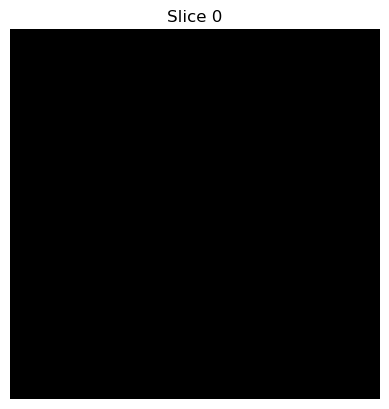

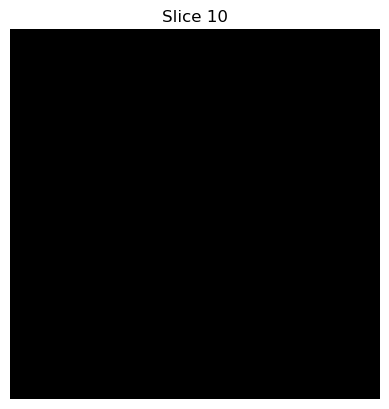

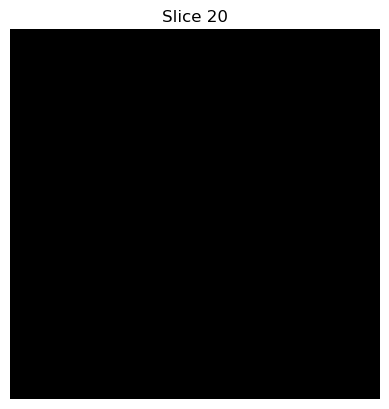

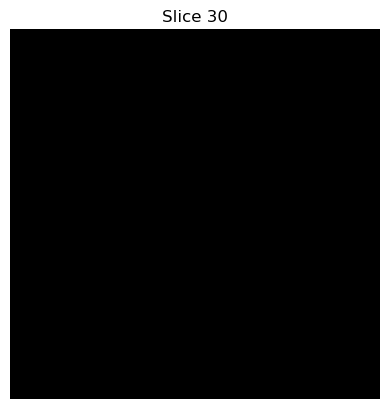

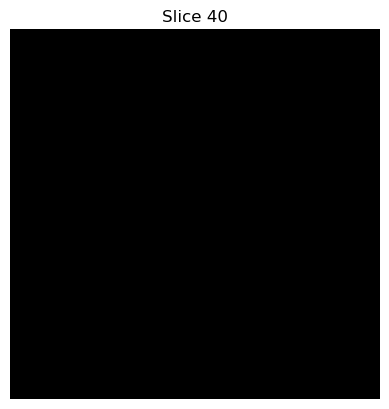

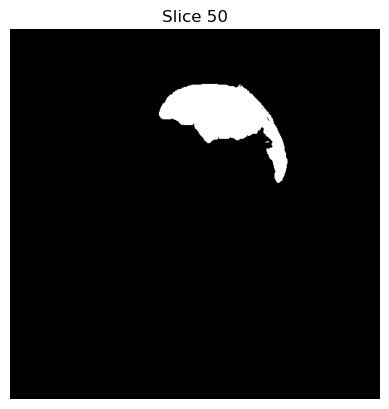

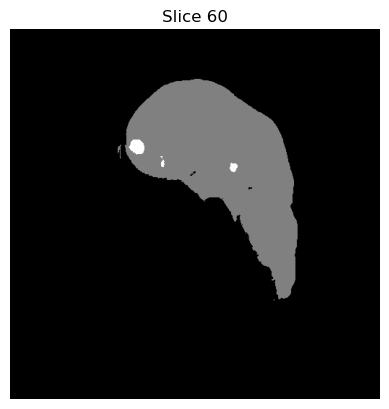

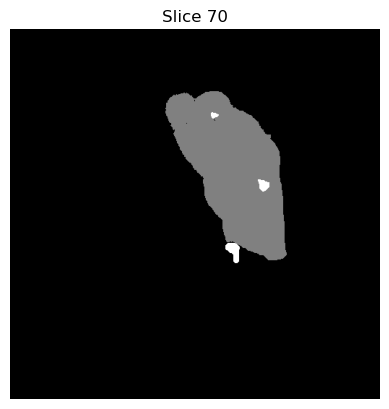

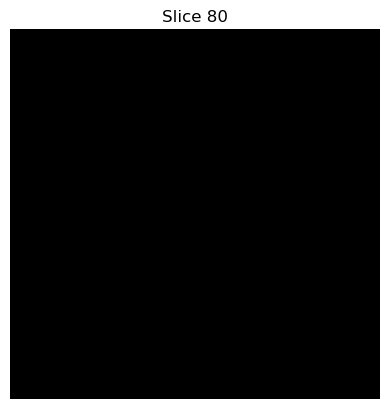

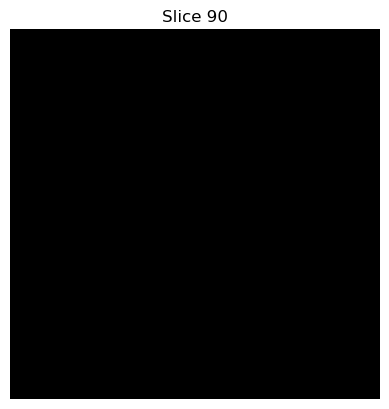

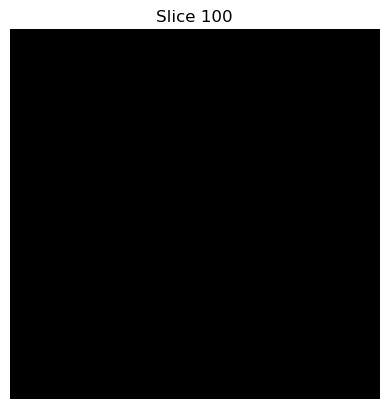

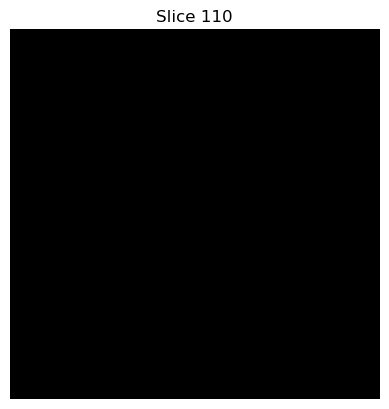

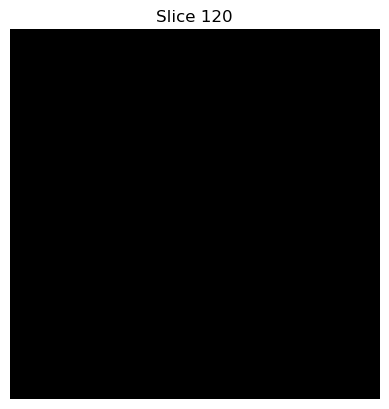

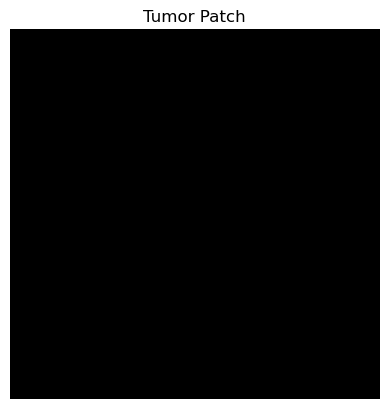

In [28]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load the segmentation file
segmentation_path = r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\dataset\segmentations\segmentation-1.nii"
segmentation = nib.load(segmentation_path)

# Extract the data array
segmentation_data = segmentation.get_fdata()

# Find unique values in the data
unique_values = np.unique(segmentation_data)
print("Unique values in the segmentation data:", unique_values)

# Function to plot slices
def plot_slice(slice_data, title):
    plt.imshow(slice_data, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize a few slices to find the tumor
for i in range(0, segmentation_data.shape[2], 10):  # Adjust the step size as needed
    plot_slice(segmentation_data[:, :, i], f'Slice {i}')

# Assuming you have identified the tumor value (e.g., 2)
tumor_value = 2  # Replace with the correct value

# Extract a patch with a tumor
# Adjust the slice number and coordinates as needed based on your visual inspection
tumor_patch = segmentation_data[100:200, 100:200, 50]  # Example coordinates
tumor_mask_patch = np.where(tumor_patch == tumor_value, 1, 0)

# Visualize the tumor patch
plot_slice(tumor_mask_patch, 'Tumor Patch')

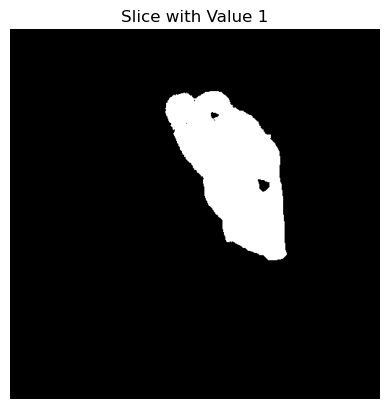

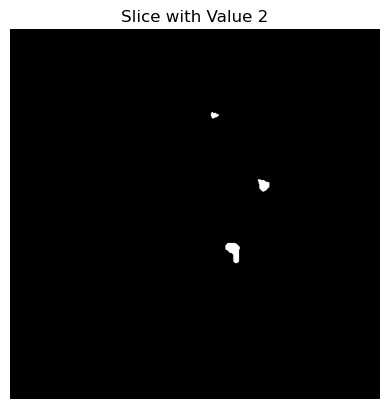

In [29]:
import matplotlib.pyplot as plt

# Function to plot slices with specific value
def plot_masked_slice(slice_data, value, title):
    masked_slice = np.where(slice_data == value, slice_data, 0)
    plt.imshow(masked_slice, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Choose a slice number for visualization
slice_number = 70  # Adjust this based on your data

# Visualize the slice with only value 1
plot_masked_slice(segmentation_data[:, :, slice_number], 1, 'Slice with Value 1')

# Visualize the slice with only value 2
plot_masked_slice(segmentation_data[:, :, slice_number], 2, 'Slice with Value 2')